In [11]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [12]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-04-23 04:54:54--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.1’

book-crossings.zip. 100%[===================>]  24.88M   132MB/s    in 0.2s    

2025-04-23 04:54:54 (132 MB/s) - ‘book-crossings.zip.1’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Book-Ratings.csv     
replace BX-Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Books.csv            
replace BX-Users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Users.csv            


In [13]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

Books dataframe shape: (271379, 3)
Ratings dataframe shape: (1149780, 3)

Missing values in Books dataframe:
isbn      0
title     0
author    2
dtype: int64

Missing values in Ratings dataframe:
user      0
isbn      0
rating    0
dtype: int64


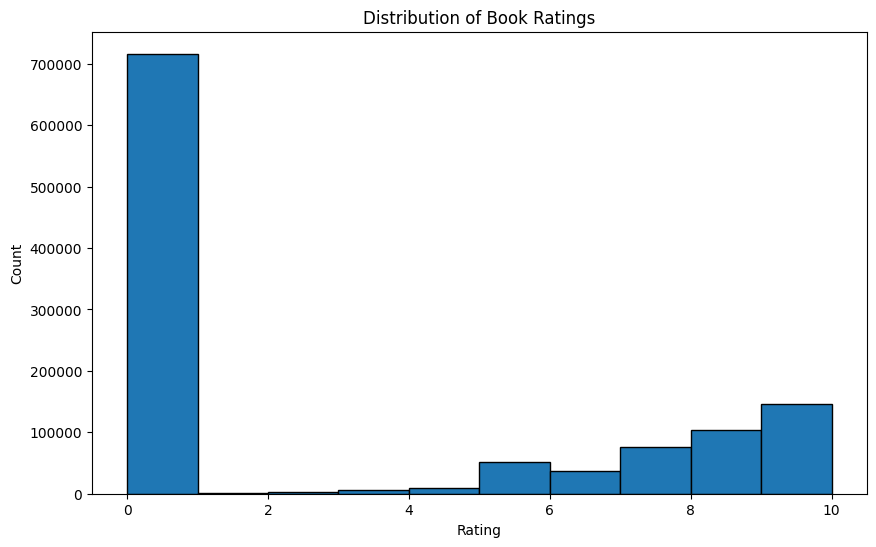


Median number of ratings per user: 1.0
Mean number of ratings per user: 10.92

Median number of ratings per book: 1.0
Mean number of ratings per book: 3.38


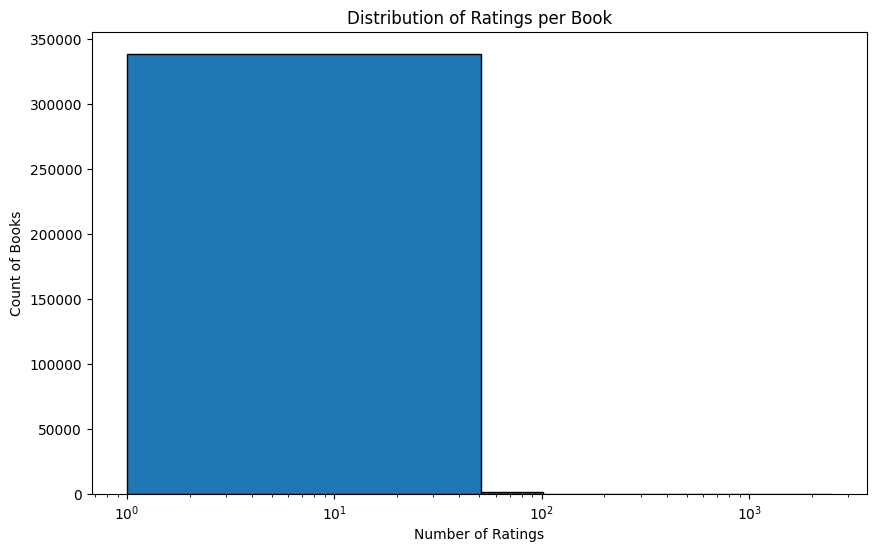

In [14]:
# add your code here - consider creating a new cell for each section of code

# Print the shape of dataframes
print(f"Books dataframe shape: {df_books.shape}")
print(f"Ratings dataframe shape: {df_ratings.shape}")

# Check for missing values
print("\nMissing values in Books dataframe:")
print(df_books.isnull().sum())
print("\nMissing values in Ratings dataframe:")
print(df_ratings.isnull().sum())

# Display distribution of ratings
plt.figure(figsize=(10, 6))
plt.hist(df_ratings['rating'], bins=10, edgecolor='black')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Count of ratings per user
user_ratings_count = df_ratings.groupby('user').size()
print(f"\nMedian number of ratings per user: {user_ratings_count.median()}")
print(f"Mean number of ratings per user: {user_ratings_count.mean():.2f}")

# Count of ratings per book
book_ratings_count = df_ratings.groupby('isbn').size()
print(f"\nMedian number of ratings per book: {book_ratings_count.median()}")
print(f"Mean number of ratings per book: {book_ratings_count.mean():.2f}")

# Visualize distribution of ratings per book
plt.figure(figsize=(10, 6))
plt.hist(book_ratings_count, bins=50, edgecolor='black')
plt.title('Distribution of Ratings per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Books')
plt.xscale('log')
plt.show()

In [15]:
# Filter users with at least 200 ratings
user_counts = df_ratings['user'].value_counts()
users_with_min_ratings = user_counts[user_counts >= 200].index
df_ratings_filtered = df_ratings[df_ratings['user'].isin(users_with_min_ratings)]

print(f"Users with at least 200 ratings: {len(users_with_min_ratings)}")
print(f"Ratings after filtering users: {df_ratings_filtered.shape[0]}")

# Filter books with at least 100 ratings
book_counts = df_ratings_filtered['isbn'].value_counts()
books_with_min_ratings = book_counts[book_counts >= 100].index
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered['isbn'].isin(books_with_min_ratings)]

print(f"Books with at least 100 ratings: {len(books_with_min_ratings)}")
print(f"Ratings after filtering books: {df_ratings_filtered.shape[0]}")

# Get the list of books in our filtered ratings
filtered_books_df = df_books[df_books['isbn'].isin(books_with_min_ratings)]

# Create dictionaries for quick lookups
isbn_to_title = dict(zip(filtered_books_df['isbn'], filtered_books_df['title']))
title_to_isbn = dict(zip(filtered_books_df['title'], filtered_books_df['isbn']))

Users with at least 200 ratings: 905
Ratings after filtering users: 527556
Books with at least 100 ratings: 100
Ratings after filtering books: 13793


In [16]:
# Create the pivot table with books as indices and users as columns
books_users_pivot = df_ratings_filtered.pivot(index='isbn', columns='user', values='rating').fillna(0)

# Convert to sparse matrix
books_users_matrix = csr_matrix(books_users_pivot.values)

# Create and train the model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(books_users_matrix)

print(f"Shape of pivot table: {books_users_pivot.shape}")
print(f"Number of books in the pivot table: {len(books_users_pivot.index)}")

Shape of pivot table: (100, 857)
Number of books in the pivot table: 100


In [17]:
def get_recommends(book=""):
    # Check if the book exists in our dataset
    if book not in title_to_isbn:
        print(f"Book '{book}' not found in the filtered dataset")
        return [book, [["Book not in dataset", 0]]]

    # Get the ISBN for the book
    book_isbn = title_to_isbn[book]

    # Check if the ISBN is in our pivot table
    if book_isbn not in books_users_pivot.index:
        print(f"Book ISBN '{book_isbn}' not in pivot table")
        return [book, [["Book not in pivot table", 0]]]

    # Find the index of the book in the pivot table
    book_index = books_users_pivot.index.get_loc(book_isbn)

    # Get distances and indices of k-nearest neighbors
    distances, indices = model_knn.kneighbors(
        books_users_matrix[book_index:book_index+1],
        n_neighbors=6  # k+1 to include the book itself
    )

    # Create the recommendation list
    recommendations = []
    for i in range(1, 6):  # Skip the first one (index 0) as it's the input book
        neighbor_isbn = books_users_pivot.index[indices[0][i]]
        neighbor_title = isbn_to_title[neighbor_isbn]
        distance = distances[0][i]
        recommendations.append([neighbor_title, float(distance)])

    # Return book title and recommendations
    return [book, recommendations]

In [18]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Lovely Bones: A Novel', 0.7234864234924316], ["The Pilot's Wife : A Novel", 0.8192678689956665], ['The Joy Luck Club', 0.8198604583740234], ['The Notebook', 0.8236683011054993], ['Bel Canto: A Novel', 0.8247874975204468]]]
You haven't passed yet. Keep trying!
